##### Order of Operation
1. import
2. read in training data 
3. clean data 
4. stem words with snowball stemmer
5. pipeline tfidf vectorizer, [selected classifier]
6. choose best pipeline
7. gridsearchcv on pipeline to find best tuned classifier
8. test on other data i.e. Kaggle, friends, etc...

## Introduction
In this project, I try to optimize a supervised machine learning algorithm to predict Myers-Briggs personality profiles of Kaggle forum users based on the [(MBTI) Myers-Briggs Personality Type Dataset](https://www.kaggle.com/datasnaek/mbti-type) on Kaggle. 

This notebook was forked from [this](https://www.kaggle.com/lbronchal/what-s-the-personality-of-kaggle-users) Kaggle kernel. 

In [55]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

In [23]:
train_data = pd.read_csv('../mbti-project/mbti_1.csv')
user_data = pd.read_csv('../mbti-project/Users.csv')
forum_data = pd.read_csv('../mbti-project/ForumMessages.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

Let's look at the structure of the dataset.

In [24]:
train_data.shape

(8675, 2)

Let's look at the distribution of personality profile types in the training data.

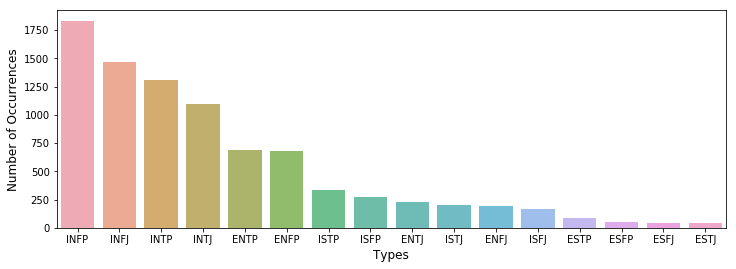

In [25]:
type_count = train_data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(type_count.index, type_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

The personality types seems to be heavily skewed to the right.

Let's see if there are missing values in our data.

In [26]:
print('Forum Missing Values:')
print(forum_data.isnull().sum())
print('\n')
print('User Missing Values:')
print(user_data.isnull().sum())
print('\n')
print('Training Missing Values:')
print(train_data.isnull().sum())

Forum Missing Values:
Id                           0
ForumTopicId                 0
AuthorUserId                 0
PostDate                     0
Message                    581
ReplyToForumMessageId    70620
TopicMessagePosition         0
RawMarkdown              60694
Score                        0
FlaggedCount                 0
dtype: int64


User Missing Values:
Id                     0
UserName          267200
DisplayName           21
RegisterDate           0
Points            510138
Ranking           510138
Tier                   0
HighestRanking    510132
dtype: int64


Training Missing Values:
type     0
posts    0
dtype: int64


Fill missing values for `forum_data['Message']` with blank space.

In [27]:
forum_data['Message'] = forum_data['Message'].fillna('')

print('Forum Missing Values:')
print(forum_data.isnull().sum())

Forum Missing Values:
Id                           0
ForumTopicId                 0
AuthorUserId                 0
PostDate                     0
Message                      0
ReplyToForumMessageId    70620
TopicMessagePosition         0
RawMarkdown              60694
Score                        0
FlaggedCount                 0
dtype: int64


In [28]:
print(forum_data['AuthorUserId'].value_counts())

3258      1459
993       1353
2242      1191
59561     1011
5309       913
114978     699
1828       679
100236     604
6696       510
24266      499
317687     488
75837      451
2505       436
140793     390
368        377
23831      376
3716       375
263583     362
111776     341
147404     323
1335       320
4398       315
37404      310
111640     284
102203     264
381        263
2194       253
10035      239
2036       239
131576     237
          ... 
138735       1
2839         1
201524       1
217916       1
111072       1
405968       1
80305        1
391593       1
231655       1
116975       1
80113        1
170245       1
49422        1
55030        1
10515        1
31001        1
233764       1
366885       1
397037       1
217404       1
145130       1
158043       1
637281       1
51599        1
405904       1
358082       1
155303       1
131478       1
389544       1
14329        1
Name: AuthorUserId, Length: 13340, dtype: int64


Since a given user might have posted more than once on Kaggle forums, I will group all `'Message'` together for each unique user.

In [29]:
forum_data_agg = forum_data.groupby('AuthorUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()

In [30]:
print(forum_data_agg)

       AuthorUserId                                            Message
0                62  tes Vateesh, thanks for alerting us to this. C...
1               368  The public leaderboard is only indicative beca...
2               381  <p>Having exact reproducibility will definitel...
3               387  <p>From an economic perspective let's look at ...
4               392  <p>Hi all and congrats to the winners and all ...
5               412  <p>Hi guys,</p>\n<p>I've often been frustrated...
6               417  <p>Please remove my entry also - I mixed up te...
7               421  <p>Hello kagglers!</p>\n<p>I want to ask you i...
8               424  Hi all,<BR><BR>When I submit, the form asks me...
9               439  Does this mean that even if someone wins round...
10              450  There's also this piece from the BBC on the <a...
11              451  <p>Well done to the winners. I am interested i...
12              464  <p>Nice point. I seem to have missed out on do...
13    

In [31]:
print(forum_data_agg['AuthorUserId'].value_counts())

71677     1
151016    1
494738    1
2708      1
126473    1
121486    1
19084     1
27272     1
605816    1
33413     1
43648     1
643711    1
518776    1
137846    1
45683     1
47730     1
43632     1
348783    1
62059     1
326250    1
21284     1
27240     1
397927    1
203366    1
33381     1
23198     1
144035    1
129706    1
105158    1
552523    1
         ..
406442    1
277709    1
13516     1
595094    1
449793    1
617783    1
58666     1
320822    1
294197    1
301551    1
118067    1
77103     1
146733    1
13612     1
38022     1
345378    1
87328     1
7108      1
629725    1
40435     1
202008    1
58646     1
51550     1
96258     1
285969    1
61922     1
9486      1
460042    1
138505    1
327680    1
Name: AuthorUserId, Length: 13340, dtype: int64


Clean `train_data['posts']`.

In [56]:
#function to clean data
def clean_text(text):
    #get rid of html and seperators
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r' ', text)
    #get rid of punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    #get rid of numbers
    text = ''.join(i for i in text if not i.isdigit())
    return text

In [57]:
train_data['clean_posts'] = train_data['posts'].apply(clean_text)

Now, I'll stem the words.

In [59]:
#function to stem words
def stem_text(text):
    stemmer = SnowballStemmer('english')
    words_list = text.split()
    new_list = []
    for i in words_list:
        word = stemmer.stem(i)
        new_list.append(word)
        
    words = new_list
    words = ' '.join(words)
    return words

In [60]:
train_data['clean_posts'] = train_data['clean_posts'].apply(stem_text)

In [61]:
print(train_data['clean_posts'][0])

enfp and intj moment sportscent not top ten play prank what has been the most lifechang experi in your life on repeat for most of today may the perc experi immers you the last thing my infj friend post on his facebook befor commit suicid the next day rest in peac hello enfj sorri to hear of your distress it onli natur for a relationship to not be perfect all the time in everi moment of exist tri to figur the hard time as time of growth as welcom and stuff game set match prozac wellbrutin at least thirti minut of move your leg and i dont mean move them while sit in your same desk chair weed in moder mayb tri edibl as a healthier altern basic come up with three item youv determin that each type or whichev type you want to do would more than like use given each type cognit function and whatnot when left by all thing in moder sim is inde a video game and a good one at that note a good one at that is somewhat subject in that i am not complet promot the death of ani given sim dear enfp what 

Now, I'll build my pipeline and test a few different classifiers.